<a href="https://colab.research.google.com/github/Kitwradr/Project-Automatic-playlist-continuation/blob/main/svdvsncf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVD vs. Neural Collaborative Filtering for Automatic Playlist Continuation 

## Imports

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626473 sha256=04467e45dd3d152faab5db8cb48af47fd69adf4bbb219a2ea8756965860cce76
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [ ]:
import tensorflow
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt

import heapq
import math
from collections import defaultdict
from tqdm import tqdm
import random

from sklearn.model_selection import train_test_split

from surprise import SVD, Reader, Dataset, SVDpp

from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Concatenate, Dropout, Dot
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotNormal, LecunUniform
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import BinaryCrossentropy
from keras.utils import plot_model

## Fetch Processed Data

**If you are running the following cells, please make sure the paths to the data files are correct.**

In [ ]:
train_wnegatives=pd.read_csv('/content/drive/MyDrive/dsc210/project/train_with_negative.csv')
# fetch the positive samples to build necessary data structures later
train_positives=train_wnegatives[train_wnegatives.label==1][['pid','tid']].reset_index(drop=True)

In [ ]:
# preprocessing the columns
train_wnegatives['album_share']=train_wnegatives['album-artist share'].apply(lambda x:float(x.strip('[]').split(', ')[0]))
train_wnegatives['artist_share']=train_wnegatives['album-artist share'].apply(lambda x:float(x.strip('[]').split(', ')[1]))

In [ ]:
train_wnegatives.head(5)

,pid,tid,label,album-artist share,album_share,artist_share
0,19647,11777,1,"[0.03333333333333333, 0.09444444444444444]",0.033333,0.094444
1,19647,203958,0,"[0.0, 0.0]",0.000000,0.000000
2,18906,5713,1,"[0.1267605633802817, 0.1267605633802817]",0.126761,0.126761
3,18906,2287,0,"[0.0, 0.0]",0.000000,0.000000
4,18980,39,1,"[0.007407407407407408, 0.014814814814814815]",0.007407,0.014815


Validation and Test sets

In [ ]:
valid_wnegatives=pd.read_csv('/content/drive/MyDrive/dsc210/project/valid_negatives.csv')
test_wnegatives=pd.read_csv('/content/drive/MyDrive/dsc210/project/test_negatives.csv')

In [ ]:
valid_wnegatives.head(5)

,pid,tid,negatives
0,12148,52790,"[89576, 34652, 166523, 74965, 179961, 120204, ..."
1,19584,3065,"[171063, 27548, 226717, 235666, 46777, 92661, ..."
2,5347,28372,"[123373, 146795, 152598, 162092, 37588, 111716..."
3,1571,12076,"[154323, 129562, 205307, 150986, 49469, 171484..."
4,13154,2031,"[24655, 178775, 125477, 58145, 184238, 5010, 1..."


Track Metadata

In [ ]:
tracks=pd.read_csv('/content/drive/MyDrive/dsc210/project/tracks.csv')
tracks_dict=tracks.to_dict()

## Necessary Data Structures

These are build using the positive samples in the train set

In [ ]:
# set of all playlists present in the train set
train_playlists=set(np.unique(train_positives.pid))
# set of all tracks present in the train set
train_tracks=set(np.unique(train_positives.tid))
# set of all interactions in train set
unique_interaction_set=set([(p,t) for p,t in train_positives.values])
# dictionary (playlist_id: number of tracks in playlist)
tracksInPlaylist=defaultdict(int,train_positives.pid.value_counts().to_dict())

In [ ]:
# dictionary (playlist: set of tracks in playlist)
tracksPerPlaylist=defaultdict(set)
# dictionary (track: set of playlist with track)
playlistsPerTrack=defaultdict(set)
# dictionary (playlist: dictionary (album: number of tracks from album in playlist))
artistCountInPlaylist=defaultdict(lambda: defaultdict(int))
# dictionary (playlist: dictionary (artist: number of tracks by artist in playlist))
albumCountInPlaylist=defaultdict(lambda: defaultdict(int))
# set of all tracks in train set
allTracks=set()
for p,t in tqdm(train_positives[['pid','tid']].values):
  tracksPerPlaylist[p].add(t)
  playlistsPerTrack[t].add(p)
  allTracks.add(t)
  artistCountInPlaylist[p][tracks_dict['artist_uri'][t]]+=1
  albumCountInPlaylist[p][tracks_dict['album_uri'][t]]+=1

100%|██████████| 1061543/1061543 [00:12<00:00, 88222.24it/s]


## Evaluation Metrics

In [ ]:
# Hit Ratio
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

# NDCG
def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

## NLA Approach: Singular Value Decomposition (SVD)

### Setup data for training

In [ ]:
reader = Reader(rating_scale=(0, 1))
dataSVD = Dataset.load_from_df(train_wnegatives[['pid','tid','label']].sort_values(by='pid'), reader)
trainSVD = dataSVD.build_full_trainset()

### Fit SVD

In [ ]:
svd_model = SVD(n_factors=4, n_epochs=10, biased=False)
svd_model.fit(trainSVD)

Function to calculate Hit Ratio and NDCG metrics on SVD models

In [ ]:
def evaluate_SVD_model(model,df):
  # dictionary to collect metrics over different K
  ndcgs_dict=defaultdict(list)
  hrs_dict=defaultdict(list)

  # list of tracks and playlists in train set with negative samples
  set_tracks=np.unique(train_wnegatives.tid)
  set_playlists=np.unique(train_wnegatives.pid)

  # calculate the performance of the model on validation set
  for p,t,neg in tqdm(df.values):
    #get prediction scores on all tracks - valid positive sample and negative tracks
    t_test=[t]+json.loads(neg)
    track_score_map={}
    for i in range(len(t_test)):
      pred=0
      if p in set_playlists and t_test[i] in set_tracks:   
        pred=model.predict(uid=trainSVD.to_inner_uid(p),
                          iid=trainSVD.to_inner_iid(t_test[i])).est
      track_score_map[t_test[i]] = pred
    
    # calculate evaluation metrics over all K - 1 to 10
    for K in range(1,11):
      ranklist = heapq.nlargest(K, track_score_map, key=track_score_map.get)
      hr = getHitRatio(ranklist, t)
      ndcg = getNDCG(ranklist, t)
      hrs_dict[K].append(hr)
      ndcgs_dict[K].append(ndcg)
  
  # Take average of the metrics    
  for K in range(1,11):
    ndcgs_dict[K]=np.array(ndcgs_dict[K]).mean()
    hrs_dict[K]=np.array(hrs_dict[K]).mean()
  return hrs_dict,ndcgs_dict

### Evaluate the SVD model on validation set

100%|██████████| 18714/18714 [00:37<00:00, 494.53it/s]


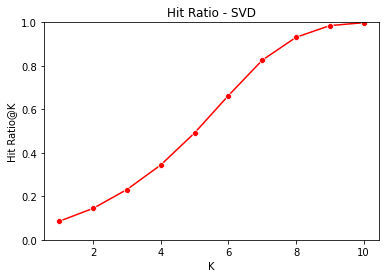

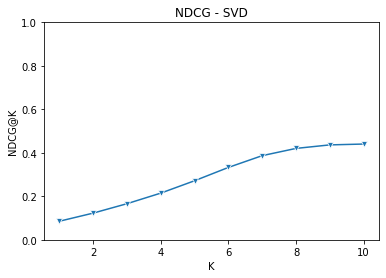

Hit Ratio@10 : 0.9985572298813722
NDCG@10 : 0.4403868061855428


In [ ]:
svd_hrs_dict,svd_ndcgs_dict=evaluate_SVD_model(svd_model,valid_wnegatives)

sns.lineplot(x=range(1,11),y=svd_hrs_dict.values(),marker='o',color='red')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('Hit Ratio@K')
plt.title('Hit Ratio - SVD')
plt.show()

sns.lineplot(x=range(1,11),y=svd_ndcgs_dict.values(),marker='v')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('NDCG@K')
plt.title('NDCG - SVD')
plt.show()

print(f'Hit Ratio@10 : {svd_hrs_dict[10]}')
print(f'NDCG@10 : {svd_ndcgs_dict[10]}')

# print(svd_hrs_dict)
# print(svd_ndcgs_dict)

## SVD with bias terms

### Fit SVD with bias terms

In [ ]:
svdb_model = SVD(n_factors=4, n_epochs=10, biased=True)
svdb_model.fit(trainSVD)

### Evaluate SVD with bias terms on validation set

100%|██████████| 18714/18714 [00:38<00:00, 482.40it/s]


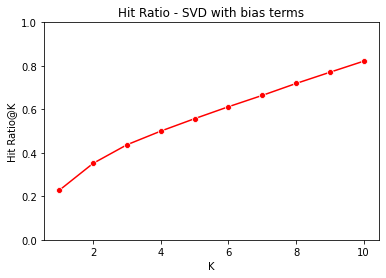

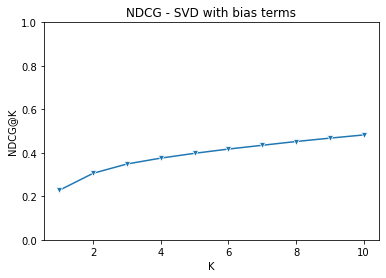

Hit Ratio@10 : 0.8214705568023939
NDCG@10 : 0.4822670857965464


In [ ]:
svdb_hrs_dict,svdb_ndcgs_dict=evaluate_SVD_model(svdb_model,valid_wnegatives)

sns.lineplot(x=range(1,11),y=svdb_hrs_dict.values(),marker='o',color='red')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('Hit Ratio@K')
plt.title('Hit Ratio - SVD with bias terms')
plt.show()

sns.lineplot(x=range(1,11),y=svdb_ndcgs_dict.values(),marker='v')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('NDCG@K')
plt.title('NDCG - SVD with bias terms')
plt.show()

print(f'Hit Ratio@10 : {svdb_hrs_dict[10]}')
print(f'NDCG@10 : {svdb_ndcgs_dict[10]}')

# print(svdb_hrs_dict)
# print(svdb_ndcgs_dict)

## SOTA approach: Neural Collaborative Filtering

### NCF Model Inputs and Labels

In [ ]:
p_input=train_wnegatives.pid.values
t_input=train_wnegatives.tid.values
m_input=[[album_s,artist_s] for album_s,artist_s in train_wnegatives[['album_share','artist_share']].values]

In [ ]:
labels=train_wnegatives.label.values

### Build NCF model

In [ ]:
# hyperparameters that gave the best result
num_factors=4 # number of latent features
lr=0.001
num_epochs=10
batch_size=256

In [ ]:
num_playlists=max(train_playlists)+1
num_tracks=max(train_tracks)+1

In [ ]:
# function that builds the NCF architecture (with input for metadata features)
def build_ncf(num_factors):
  # Input layers for playlist_id, track_id, and meta_data (album and artist shares)
  playlist_input = Input(shape=(1,), dtype='int64', name = 'playlist_input')
  track_input = Input(shape=(1,), dtype='int64', name = 'track_input')
  meta_input = Input(shape=(2,),name = 'meta_input')

  # Embedding layers for playlist latent factors
  playlist_embedding=Embedding(input_dim=num_playlists,
                            output_dim=num_factors,
                            name='playlist_embedding',
                            embeddings_initializer=GlorotNormal(),
                            embeddings_regularizer=L2(),
                            input_length=1
                            )
  # Embedding layers for track latent factors
  track_embedding=Embedding(input_dim=num_tracks,
                          output_dim=num_factors,
                          name='track_embedding',
                          embeddings_initializer=GlorotNormal(),
                          embeddings_regularizer=L2(),
                          input_length=1
                          )
  
  # Flatten the Embeddings
  playlist_factors=Flatten(name='flatten_playlist_embedding')(playlist_embedding(playlist_input))
  track_factors=Flatten(name='flatten_track_embedding')(track_embedding(track_input))

  # Concatenate playlist and track latent factors with metadata (album share, artist share)
  vector=Concatenate(name='concat_inputs')([playlist_factors,track_factors,meta_input])

  # Multi-Layer Perceptron with 3 hidden layers of 16,8,and 4 units
  # Each layer involves L2 regularlization and with ReLU activation
  layer1=Dense(16,
              kernel_regularizer=L2(),
              activation='relu',
              name='layer1'
              )(vector)
  layer2=Dense(8,
              kernel_regularizer=L2(),
              activation='relu',
              name='layer2'
              )(layer1)
  layer3=Dense(4,
              kernel_regularizer=L2(),
              activation='relu',
              name='layer3'
              )(layer2)

  # The final output layer whose weights are initialized from a uniform distribution
  # with sigmoid activation function as this is a binary classification problem
  prediction=Dense(1,
              kernel_initializer=LecunUniform(),
              activation='sigmoid',
              name='prediction'
              )(layer3)

  return Model(inputs=[playlist_input,track_input,meta_input],
              outputs=prediction)
  

Visiualize the model architecture 

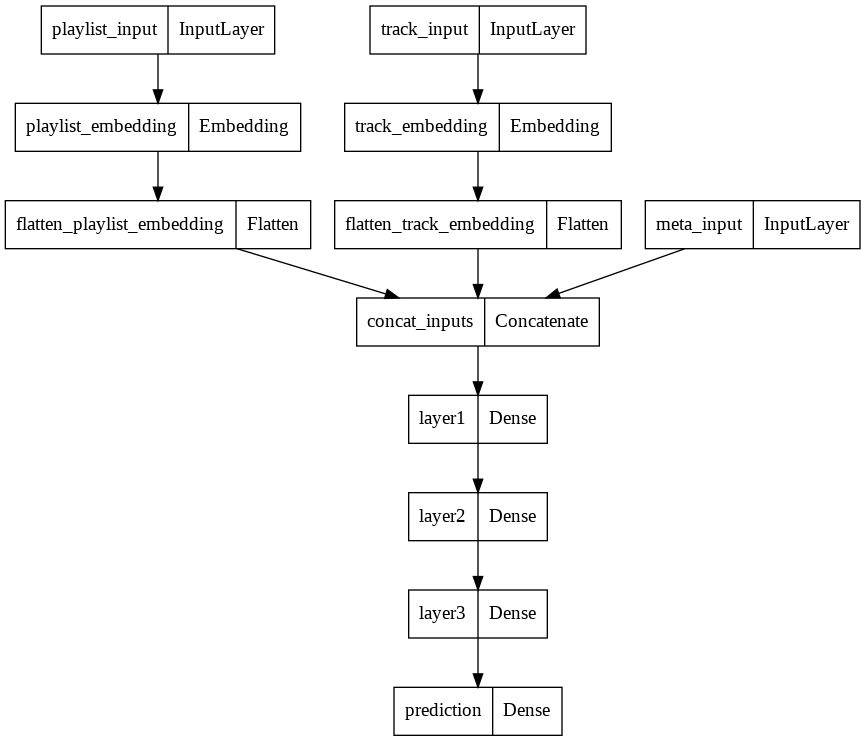

In [ ]:
from keras.utils import plot_model
model=build_ncf(num_factors)
plot_model(model)

### Function to evaluate NCF model

In [ ]:
def evaluate_NCF_model(model,df):
  # dictionary to collect metrics over different K
  ndcgs_dict=defaultdict(list)
  hrs_dict=defaultdict(list)

  # list of tracks and playlists in train set with negative samples
  set_tracks=np.unique(train_wnegatives.tid)
  set_playlists=np.unique(train_wnegatives.pid)

  # calculate the performance of the model on validation set
  for p,t,neg in tqdm(df.values):
    #get prediction scores on all tracks - valid positive sample and negative tracks
    p_test=[p for i in range(11)]
    t_test=[t]+json.loads(neg)
    m_test=[[albumCountInPlaylist[p_test[i]][tracks_dict['album_uri'][t_test[i]]]/tracksInPlaylist[p_test[i]],
            artistCountInPlaylist[p_test[i]][tracks_dict['artist_uri'][t_test[i]]]/tracksInPlaylist[p_test[i]]] for i in range(len(p_test))]
    pred=model.predict([np.array(p_test),
                        np.array(t_test),
                        np.array(m_test)], verbose=0)
    track_score_map={}
    for i in range(len(t_test)):
      track_score_map[t_test[i]] = pred[i]
    
    # calculate evaluation metrics over all K - 1 to 10
    for K in range(1,11):
      ranklist = heapq.nlargest(K, track_score_map, key=track_score_map.get)
      hr = getHitRatio(ranklist, t)
      ndcg = getNDCG(ranklist, t)
      hrs_dict[K].append(hr)
      ndcgs_dict[K].append(ndcg)
      
  # Take average of the metrics    
  for K in range(1,11):
    ndcgs_dict[K]=np.array(ndcgs_dict[K]).mean()
    hrs_dict[K]=np.array(hrs_dict[K]).mean()
  return hrs_dict,ndcgs_dict

### Training

This takes a while.

In [ ]:
ncf_model=build_ncf(num_factors=4)

# compile the model
# Stochastic Gradient Descent with Binary Cross Entropy for loss function
ncf_model.compile(optimizer=SGD(learning_rate=lr),
              loss=BinaryCrossentropy())
# train the model
history=ncf_model.fit(x=[np.array(p_input),np.array(t_input),np.array(m_input)],
                  y=np.array(labels),
                  batch_size=batch_size,
                  epochs=num_epochs,
                  shuffle=True,
                  verbose=1
                  )

Epoch 1/10
8294/8294 [==============================] - 106s 13ms/step - loss: 1.0580
Epoch 2/10
8294/8294 [==============================] - 109s 13ms/step - loss: 0.9554
Epoch 3/10
8294/8294 [==============================] - 102s 12ms/step - loss: 0.8822
Epoch 4/10
8294/8294 [==============================] - 104s 13ms/step - loss: 0.8296
Epoch 5/10
8294/8294 [==============================] - 101s 12ms/step - loss: 0.7918
Epoch 6/10
8294/8294 [==============================] - 103s 12ms/step - loss: 0.7646
Epoch 7/10
8294/8294 [==============================] - 102s 12ms/step - loss: 0.7450
Epoch 8/10
8294/8294 [==============================] - 103s 12ms/step - loss: 0.7307
Epoch 9/10
8294/8294 [==============================] - 100s 12ms/step - loss: 0.7204
Epoch 10/10
8294/8294 [==============================] - 103s 12ms/step - loss: 0.7129


Plot loss over epochs

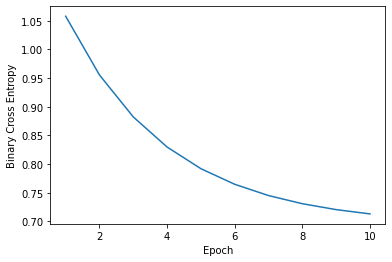

In [ ]:
sns.lineplot(x=range(1,num_epochs+1),y=history.history['loss'])
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch')
plt.show()

### Evaluate NCF model

This takes about 20 minutes.

100%|██████████| 18714/18714 [19:35<00:00, 15.92it/s]


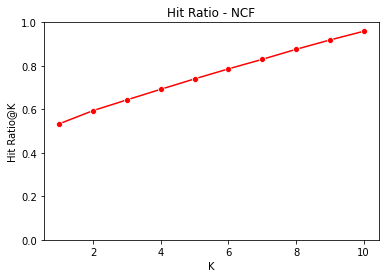

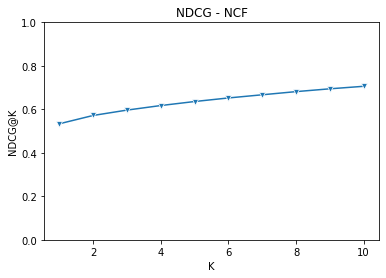

Hit Ratio@10 : 0.958961205514588
NDCG@10 : 0.7059826851131721


In [70]:
ncf_hrs_dict,ncf_ndcgs_dict=evaluate_NCF_model(ncf_model,valid_wnegatives)

sns.lineplot(x=range(1,11),y=ncf_hrs_dict.values(),marker='o',color='red')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('Hit Ratio@K')
plt.title('Hit Ratio - NCF')
plt.show()

sns.lineplot(x=range(1,11),y=ncf_ndcgs_dict.values(),marker='v')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('NDCG@K')
plt.title('NDCG - NCF')
plt.show()

print(f'Hit Ratio@10 : {ncf_hrs_dict[10]}')
print(f'NDCG@10 : {ncf_ndcgs_dict[10]}')

# print(ncf_hrs_dict)
# print(ncf_ndcgs_dict)

## Evaluating all models over test set

In [ ]:
ncf_hrs_dict,ncf_ndcgs_dict=evaluate_NCF_model(ncf_model,test_wnegatives)
svd_hrs_dict,svd_ndcgs_dict=evaluate_SVD_model(svd_model,test_wnegatives)
svdb_hrs_dict,svdb_ndcgs_dict=evaluate_SVD_model(svdb_model,test_wnegatives)

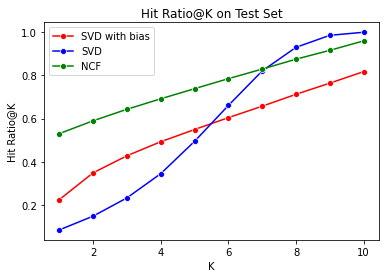

In [68]:
sns.lineplot(x=range(1,11),y=svdb_hrs_dict.values(),marker='o',color='red',label='SVD with bias')
sns.lineplot(x=range(1,11),y=svd_hrs_dict.values(),marker='o',color='blue',label='SVD')
sns.lineplot(x=range(1,11),y=ncf_hrs_dict.values(),marker='o',color='green', label='NCF')
plt.xlabel('K')
plt.ylabel('Hit Ratio@K')
plt.title('Hit Ratio@K on Test Set')
plt.show()

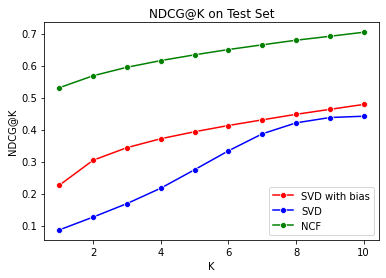

In [69]:
sns.lineplot(x=range(1,11),y=svdb_ndcgs_dict.values(),marker='o',color='red',label='SVD with bias')
sns.lineplot(x=range(1,11),y=svd_ndcgs_dict.values(),marker='o',color='blue',label='SVD')
sns.lineplot(x=range(1,11),y=ncf_ndcgs_dict.values(),marker='o',color='green', label='NCF')
plt.xlabel('K')
plt.ylabel('NDCG@K')
plt.title('NDCG@K on Test Set')
plt.show()